In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
from math import log, e
from scipy.ndimage import gaussian_filter1d
from scipy.stats import zscore
from math import floor
import leidenalg as la
import igraph as ig
from elephant.spike_train_generation import homogeneous_poisson_process
import elephant.conversion as conv
import neo as n
import quantities as pq
from quantities import Hz, s, ms

In [2]:
def normalized_cross_corr(x,y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    x_cov_std = np.nanmax(np.sqrt(np.correlate(x - x_mean, x - x_mean, 'full')))
    y_cov_std = np.nanmax(np.sqrt(np.correlate(y - y_mean, y - y_mean, 'full')))

    normalization = x_cov_std * y_cov_std
        

    unnormalized_correlation = np.correlate(x - x_mean, y - y_mean, 'full')
    
    corr_array = unnormalized_correlation/normalization

    return(corr_array)

def max_norm_cross_corr(x1, x2):
    
    correlation = normalized_cross_corr(x1, x2)
    
    lag = abs(correlation).argmax() - len(x1)+1
    
    max_corr = max(abs(correlation))
    
    return(max_corr, lag)

def cross_correlation_matrix(data):
    #input: n x t matrix where n is the number of rois and t is the duration of the time series
    #return: n x n symmetric cross correlation matrix, nxn uppertriangular cross correlation matrix and lag matrix
    n, t = data.shape
    X = np.zeros((n,n))
    lag = np.zeros((n,n))
    
    for i in range(n-1):
        for j in range(i+1,n):
            X[i][j],lag[i][j] = max_norm_cross_corr(data[i,:],data[j,:])
    X[np.isnan(X)] = 0
    lag[np.isnan(lag)] = 0
    
    X_full = X + X.T
    lag = lag + lag.T
    return(X_full, X, lag)

In [3]:
def bin_time_series(array, binsize, gaussian = True, **kwargs):
        #input: nxt matrix 
        #returns: binned time series i.e. l x n x binsize
        
    n = array.shape[0] # number of neurons
    totalsize = array.shape[1] # total duration of spikes
    gauss_array = np.zeros((n,totalsize))
    l = int(totalsize/binsize) # number of resulting layers
        
    if gaussian:
        for i in range(n):
            gauss_array[i] = gaussian_filter(array[i],kwargs['sigma'])
    else: gauss_array= array
            
    A = np.zeros((l,n,binsize))
    for i in range(l):
        A[i] = gauss_array[:,i*binsize:(i+1)*binsize]
    return(A)

def binarize(array):
    n,t = array.shape
    binary_spikes = np.zeros((n,t))
    for i in range(n):
        for j in range(t):
            if array[i][j] == 0: pass
            else: binary_spikes[i][j] = 1
    return(binary_spikes)

def gaussian_filter(array,sigma):
    #sigma=0.25==gaussian kernel with length 3
    #sigma=0.5==gaussian kernel with length 5
    #sigma=1==gaussian kernel with length 9
    return(gaussian_filter1d(array,sigma))

def jitter(spike, k):
    #jittering the given spike train
    jittered = np.zeros(spike.shape)
    for i in np.nonzero(spike)[1]:
        jitt = random.randint(-k,k)
        try:jittered[0,i+jitt] = 1
        except:jittered[0,i] = 1
    return(jittered)

def spike_count(spikes, ax, num_bins = None, t_min = None, t_max = None):
    n,t = spikes.shape
    if t_min is None: t_min = 0
    if t_max is None: t_max = t
    if t_max<=t_min: raise ValueError('t_min should be less than t_max')
    spike_count = []
    binary = binarize(spikes)
    for i in range(n):
        spike_count.append(np.sum(binary[i][t_min:t_max]))
    if num_bins is None: num_bins = int(np.max(spike_count) - np.min(spike_count))
    n, bins, patches = ax.hist(spike_count, num_bins, color = 'blue')
    ax.set_title("Spike Rate Distribution", fontsize = 25)
    ax.set_xlabel("Total Number of Spikes", fontsize = 22)
    ax.set_ylabel("Number of Neurons", fontsize = 22)
    return(n,bins)

def entropy2(labels, base=None):
#""" Computes entropy of label distribution. """

    n_labels = len(labels)

    if n_labels <= 1:
        return 0

    value,counts = np.unique(labels, return_counts = True)
    probs = counts / n_labels
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    ent = 0.

  # Compute entropy
    base = e if base is None else base
    for i in probs:
        ent -= i * log(i, base)

    return ent/log(n_labels,base)

In [55]:
num_comms = 1 # number ofcommunities to expand
spike_rate = 10 # spike rate per commiunity
comm_size = [20,20,20,20,20,20]
num_neurons = int(sum(comm_size))
bin_size = 1000.0 # in frames, in every bin_size, a community activity occurs
seconds = len(comm_size)
total_duration = int(seconds*bin_size)
window_sizes = [25, 50, 75, 100, 250, 500, 750, 1000, 1250, 1500, 2000] # size, in frames, each adjacency matrix correspond to. better to be equal to bin_size 
standard_dev = 1.2 # for gaussian kernel
k = 5 #for jittering the spikes

In [56]:
spikes = np.zeros((num_neurons,total_duration))
master_spike = np.zeros((1,total_duration))
master = homogeneous_poisson_process(rate = spike_rate*Hz, t_start = 0.0*ms, t_stop = total_duration*ms, as_array=True) 

for i,e in enumerate(master):    
    master_spike[0][int(e)] = 1
for i in range(comm_size[0]):
    spikes[i] = jitter(master_spike, 5)

comms = []
for i in range(1,len(comm_size)):
    comms.append([homogeneous_poisson_process(rate = spike_rate*Hz, t_start = 0.0*ms, t_stop = i*bin_size*ms, as_array=True) for j in range(comm_size[i])])

neuron_count = comm_size[0]
for i,e in enumerate(comms):## this is for 
    for j,f in enumerate(e):
        for k,m in enumerate(f):
            spikes[neuron_count+j][int(m)] = 1
    neuron_count = neuron_count + len(e)
            
neuron_count = comm_size[0]
for i in range(1,len(comms)+1):
    for j in range(neuron_count,neuron_count+comm_size[i]):
        for k in np.nonzero(spikes[0][(i*1000):])[0]:
            jitt = random.randint(-5,5)
            try:spikes[j,(i*1000)+k+jitt] = 1
            except:spikes[j,k] = 1
    neuron_count = neuron_count + comm_size[i]

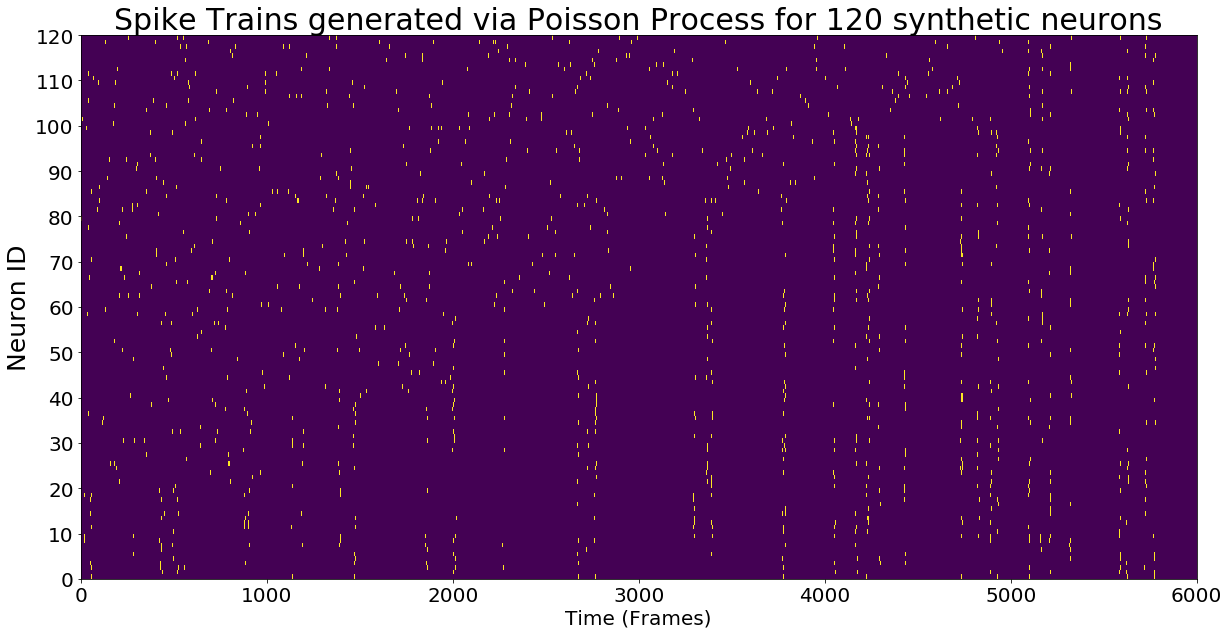

In [57]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
ax.imshow(spikes, origin = 'lower', interpolation='nearest', aspect='auto',  extent = [0,total_duration,0,num_neurons])
ax.set_title('Spike Trains generated via Poisson Process for 120 synthetic neurons', fontsize= 30)
ax.set_xlabel('TIME (in Miliseconds)', fontsize = 20)
ax.set_xticks([j*1000 for j in range(int(total_duration/1000)+1)])
ax.set_yticks([i*10 for i in range(int(num_neurons/10)+1)])
ax.set_ylabel('Neuron ID', fontsize = 25)
ax.set_xlabel('Time (Frames)', fontsize = 20)
ax.tick_params(axis = 'both', labelsize = 20)

(array([ 4.,  3.,  7.,  8., 17.,  7.,  7.,  4.,  3.,  5.,  5.,  5.,  5.,
         3.,  6.,  4.,  3.,  2.,  6.,  1.,  2.,  1.,  2.,  1.,  2.,  3.,
         0.,  2.,  0.,  0.,  1.,  0.,  1.]),
 array([42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54.,
        55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67.,
        68., 69., 70., 71., 72., 73., 74., 75.]))

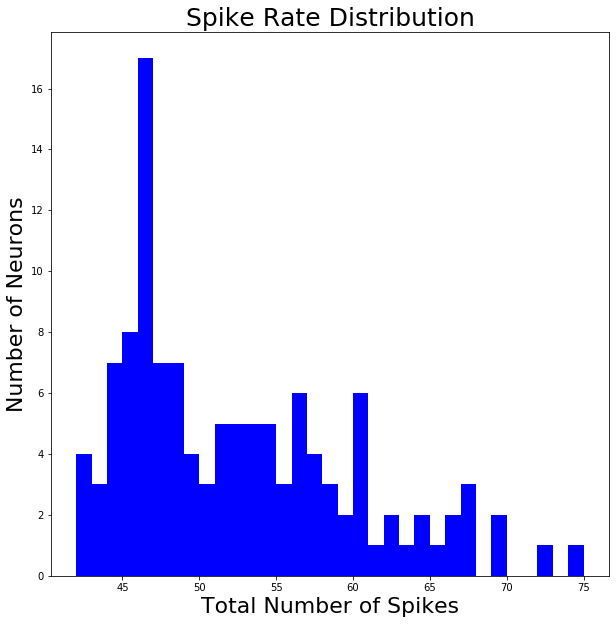

In [58]:
fig,ax = plt.subplots(1,1,figsize= (10,10))
spike_count(spikes, ax)

In [59]:
%%time
binned_spikes = {}
adjacencies = {}
for i, window_size in enumerate(window_sizes):
    binned_spikes['%d'%window_size] = bin_time_series(spikes, window_size, gaussian = True, sigma = standard_dev)
    layers = int(total_duration/window_sizes[i])
    adjacency_matrices = []
    for j in range(layers):
        adjacency_matrices.append(cross_correlation_matrix(binned_spikes['%d'%window_size][j])[0])
    adjacencies['%d'%window_size] = adjacency_matrices

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


CPU times: user 8min 58s, sys: 2.94 s, total: 9min 1s
Wall time: 9min 46s


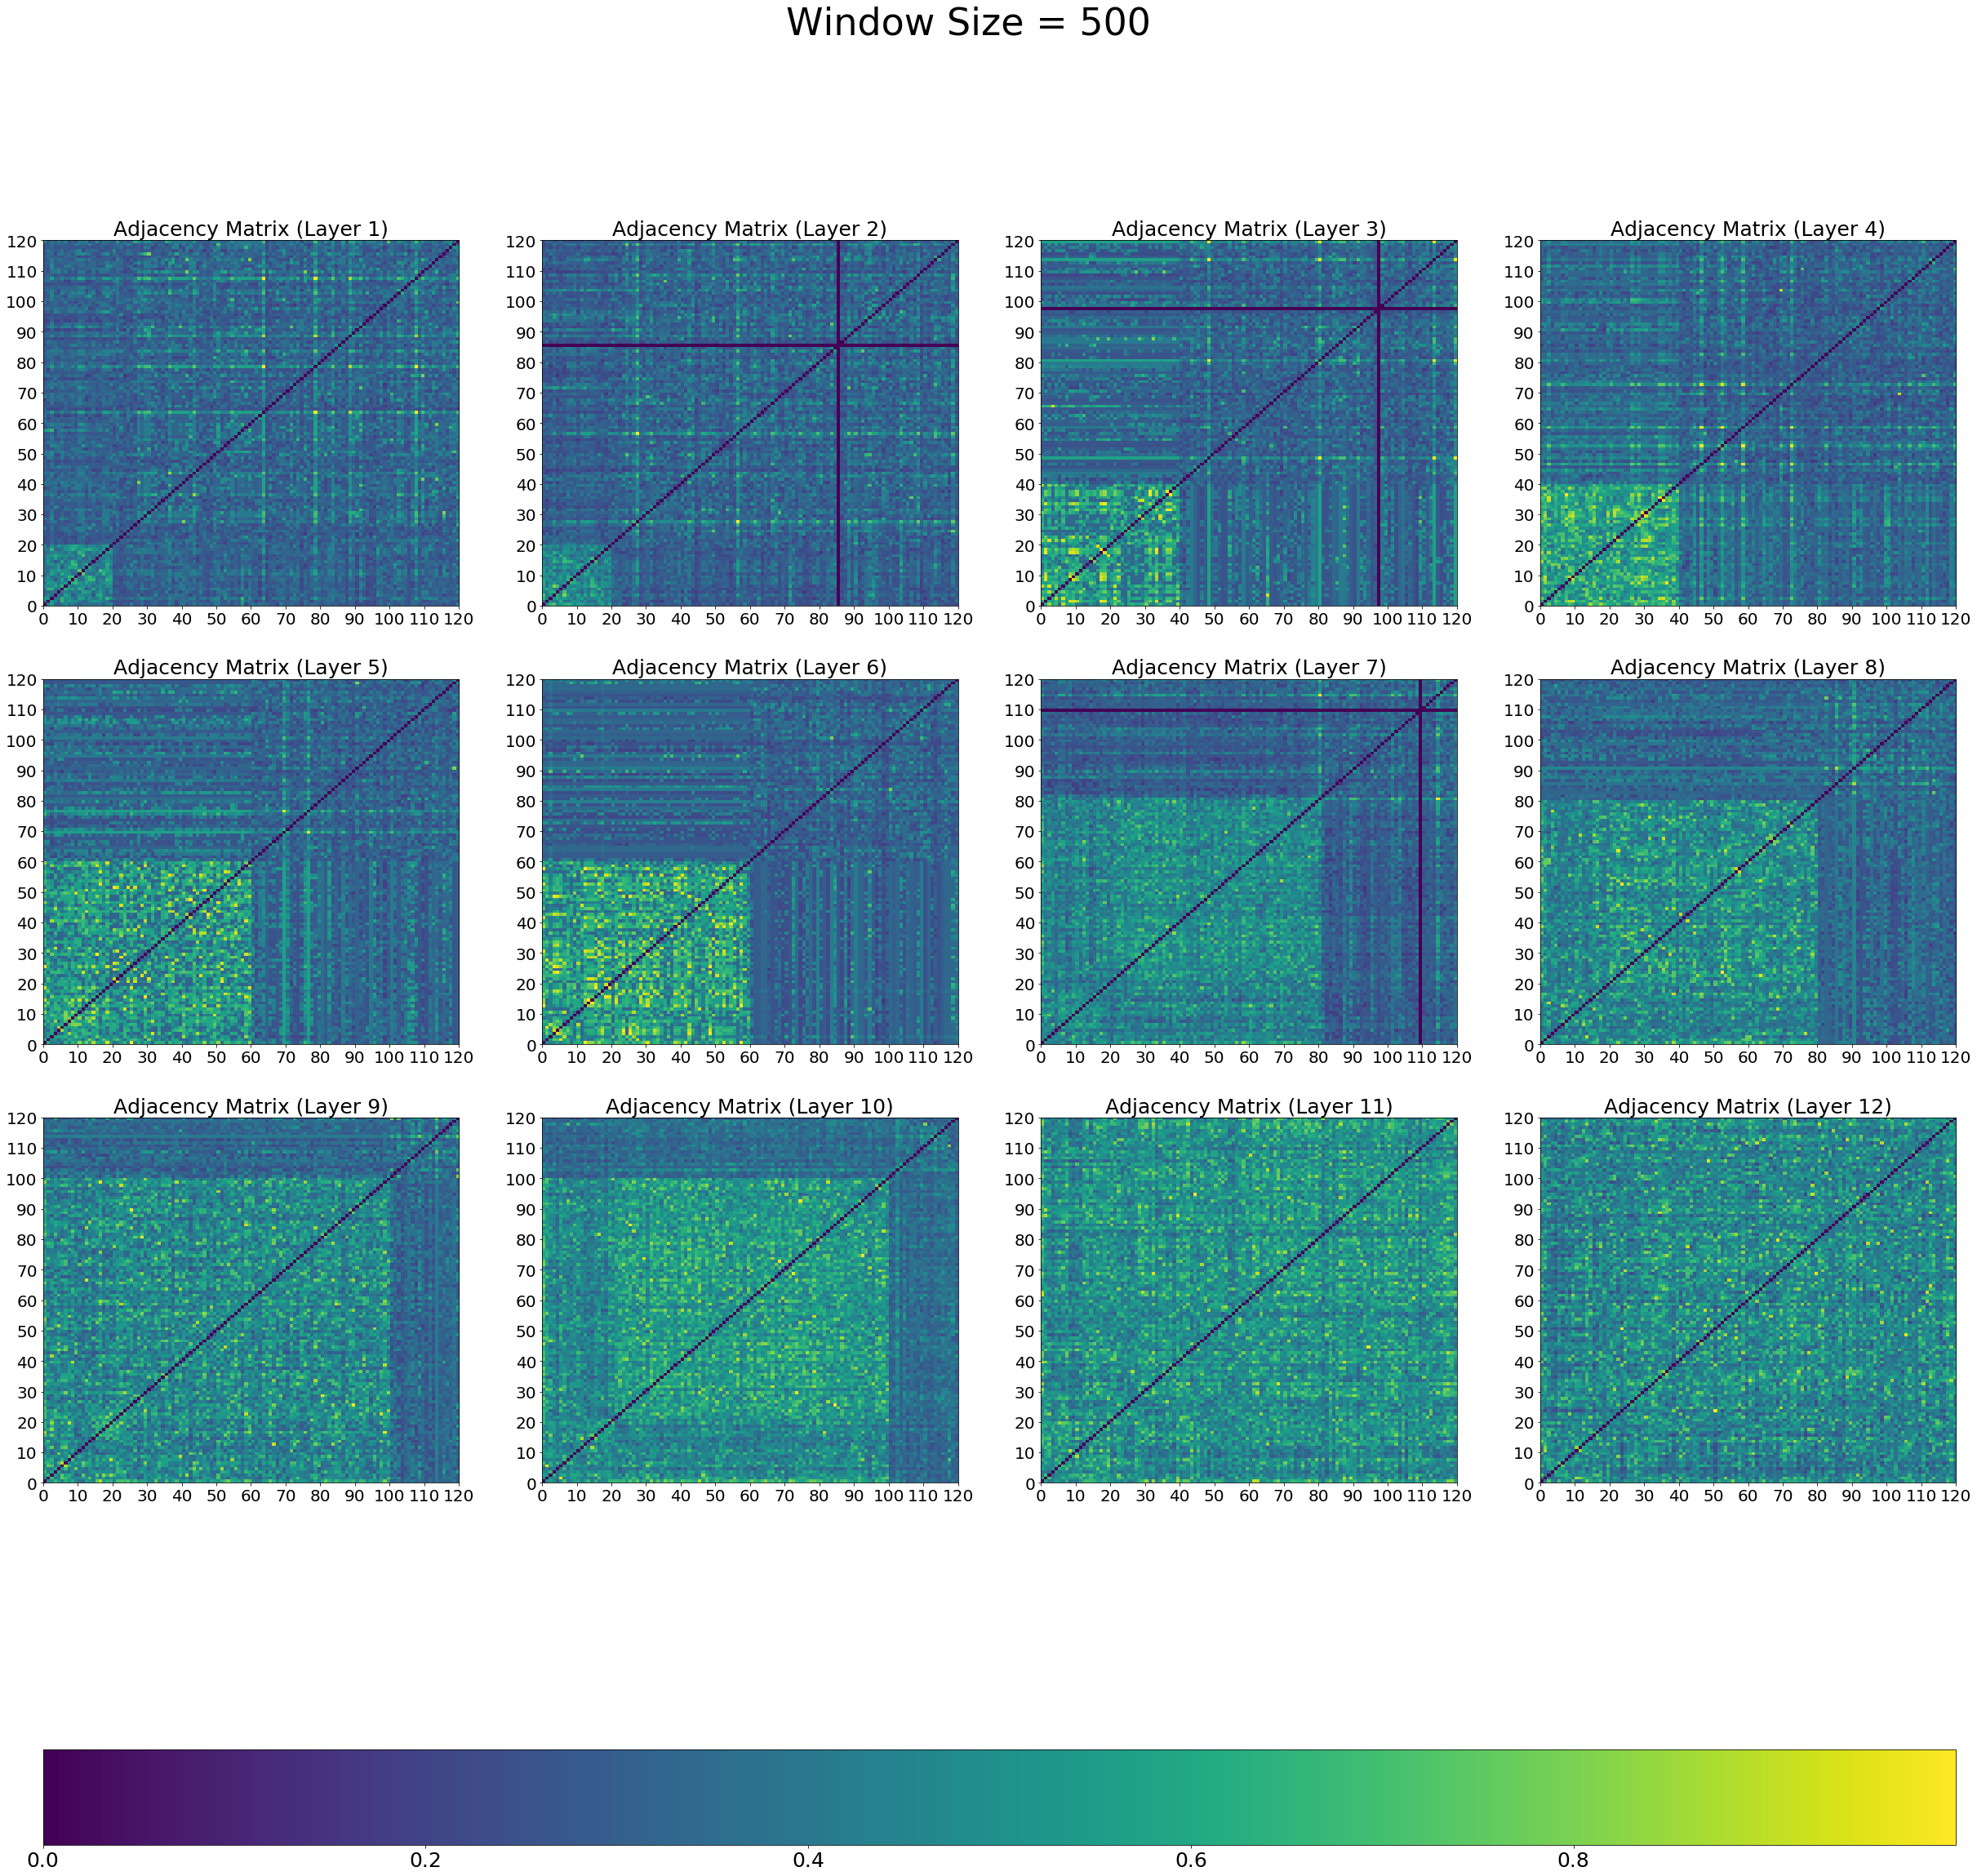

In [9]:
w = window_sizes[0]
layers = int(total_duration/w)

fig,ax = plt.subplots(3, 4, figsize = (42,40))
for i in range(3):
    for j in range(4):
        k = ax[i][j].imshow(adjacencies['%d'%w][i*4+j], 
                                origin = 'lower', 
                                interpolation='nearest', 
                                aspect='auto',  
                                extent = [0, num_neurons, 0, num_neurons])
        ax[i][j].set_title('Adjacency Matrix (Layer %d)'%(i*4+j+1), fontsize = 25)
        ax[i][j].set_xticks([k*10 for k in range(int(num_neurons/10)+1)])
        ax[i][j].set_yticks([k*10 for k in range(int(num_neurons/10)+1)])
        ax[i][j].tick_params(axis = 'both', labelsize = 20)
fig.suptitle("Window Size = %d"%w, fontsize=46)
cbar = fig.colorbar(k, ax = ax.flat, orientation = 'horizontal')
cbar.ax.tick_params(labelsize = 25) 

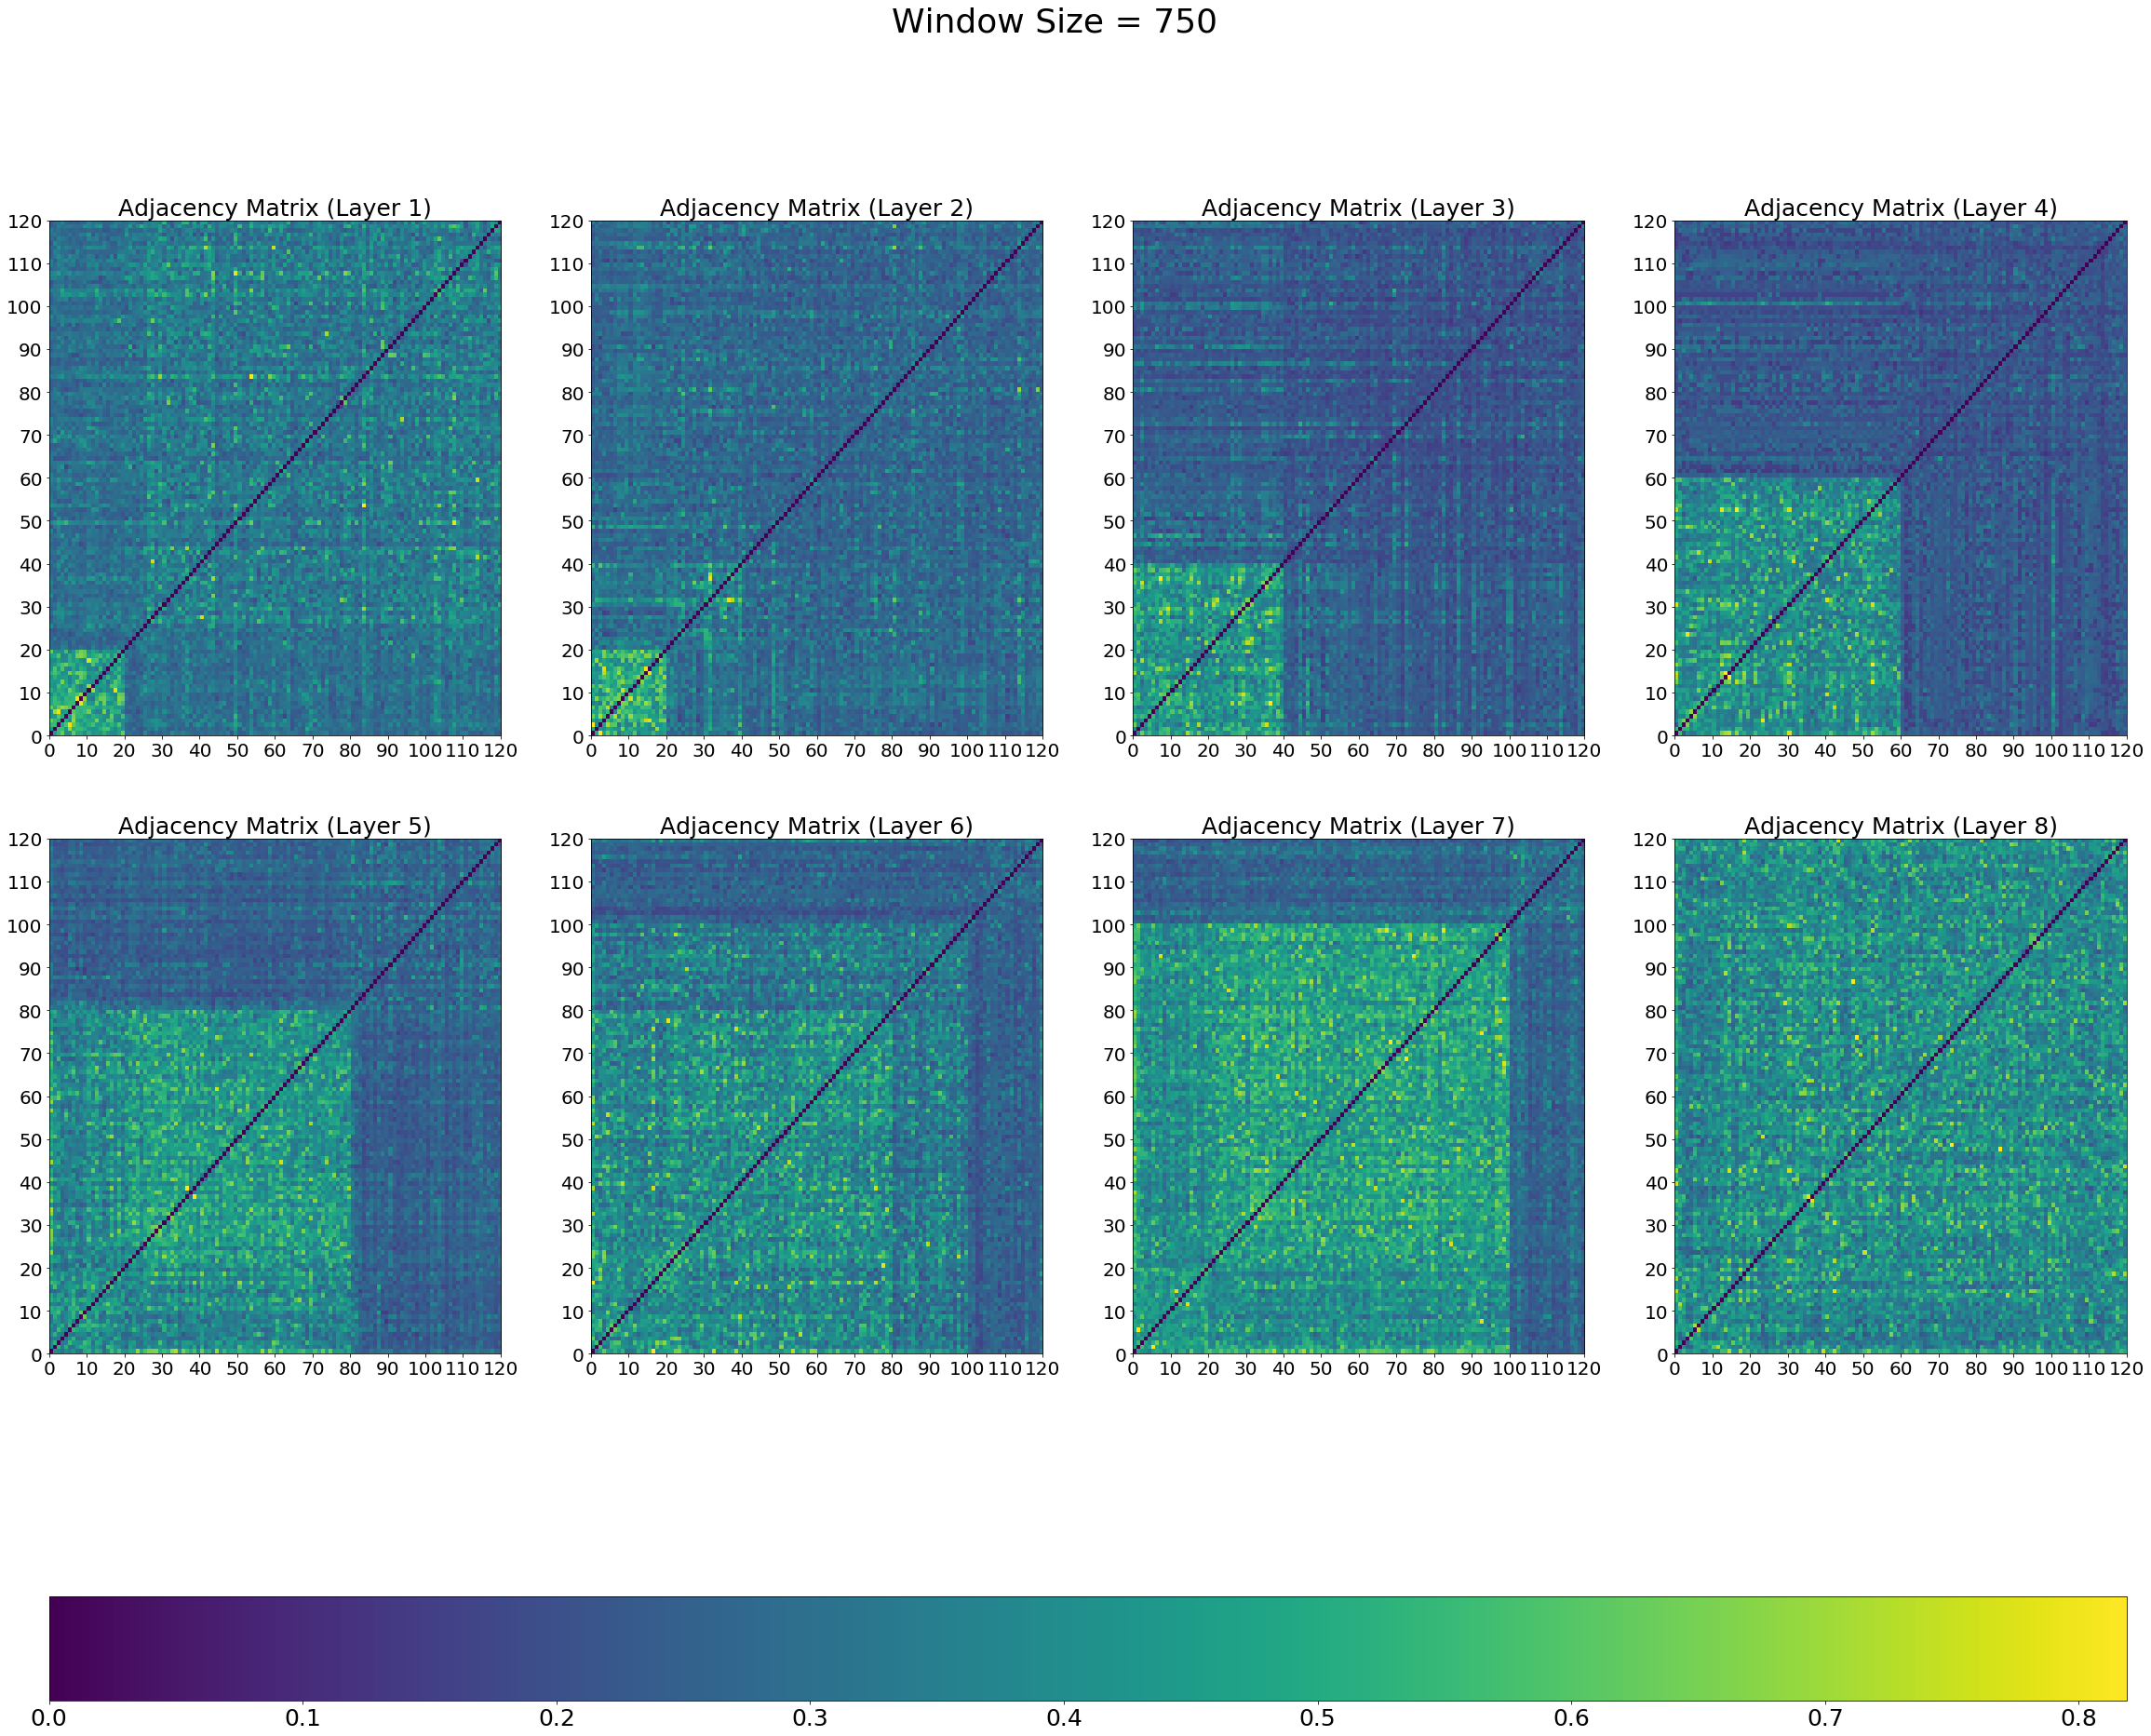

In [10]:
w = window_sizes[1]
layers = int(total_duration/w)

fig,ax = plt.subplots(2, 4, figsize = (40,32))
for i in range(2):
    for j in range(4):
        k = ax[i][j].imshow(adjacencies['%d'%w][i*4+j], 
                                origin = 'lower', 
                                interpolation='nearest', 
                                aspect='auto',  
                                extent = [0, num_neurons, 0, num_neurons])
        ax[i][j].set_title('Adjacency Matrix (Layer %d)'%(i*4+j+1), fontsize = 25)
        ax[i][j].set_xticks([k*10 for k in range(int(num_neurons/10)+1)])
        ax[i][j].set_yticks([k*10 for k in range(int(num_neurons/10)+1)])
        ax[i][j].tick_params(axis = 'both', labelsize = 20)
fig.suptitle("Window Size = %d"%w, fontsize=36)
cbar = fig.colorbar(k, ax = ax.flat, orientation = 'horizontal')
cbar.ax.tick_params(labelsize = 25) 

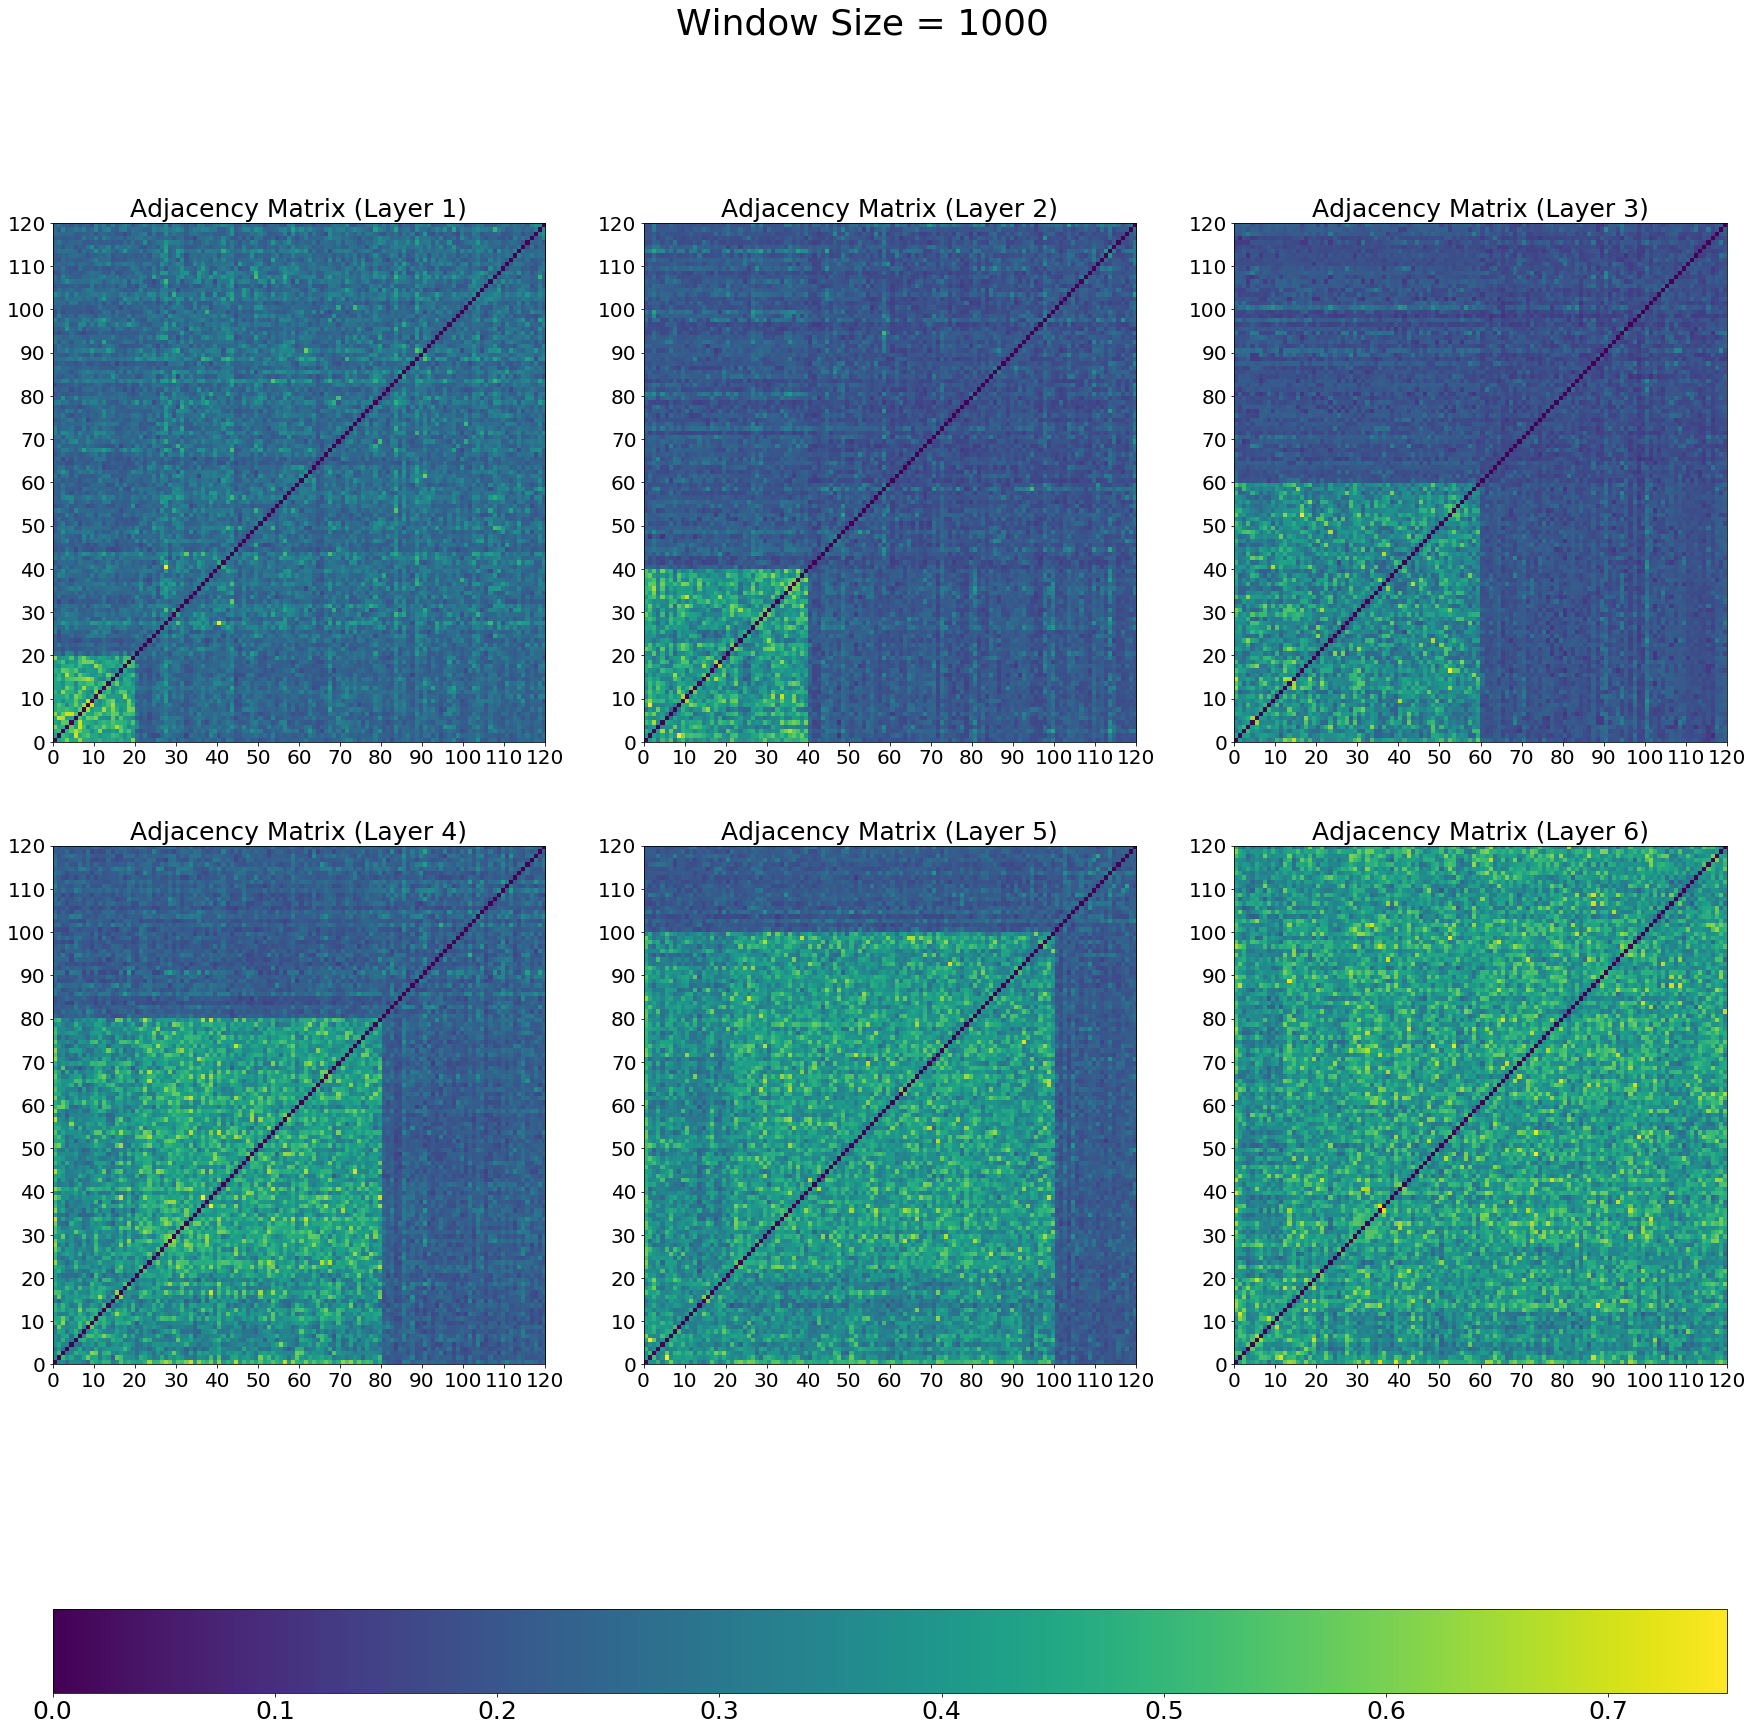

In [11]:
w = window_sizes[2]
layers = int(total_duration/w)

fig,ax = plt.subplots(2, 3, figsize = (30,30))
for i in range(2):
    for j in range(3):
        k = ax[i][j].imshow(adjacencies['%d'%w][i*3+j], 
                                origin = 'lower', 
                                interpolation='nearest', 
                                aspect='auto',  
                                extent = [0, num_neurons, 0, num_neurons])
        ax[i][j].set_title('Adjacency Matrix (Layer %d)'%(i*3+j+1), fontsize = 25)
        ax[i][j].set_xticks([k*10 for k in range(int(num_neurons/10)+1)])
        ax[i][j].set_yticks([k*10 for k in range(int(num_neurons/10)+1)])
        ax[i][j].tick_params(axis = 'both', labelsize = 20)
fig.suptitle("Window Size = %d"%w, fontsize=36)
cbar = fig.colorbar(k, ax = ax.flat, orientation = 'horizontal')
cbar.ax.tick_params(labelsize = 25) 

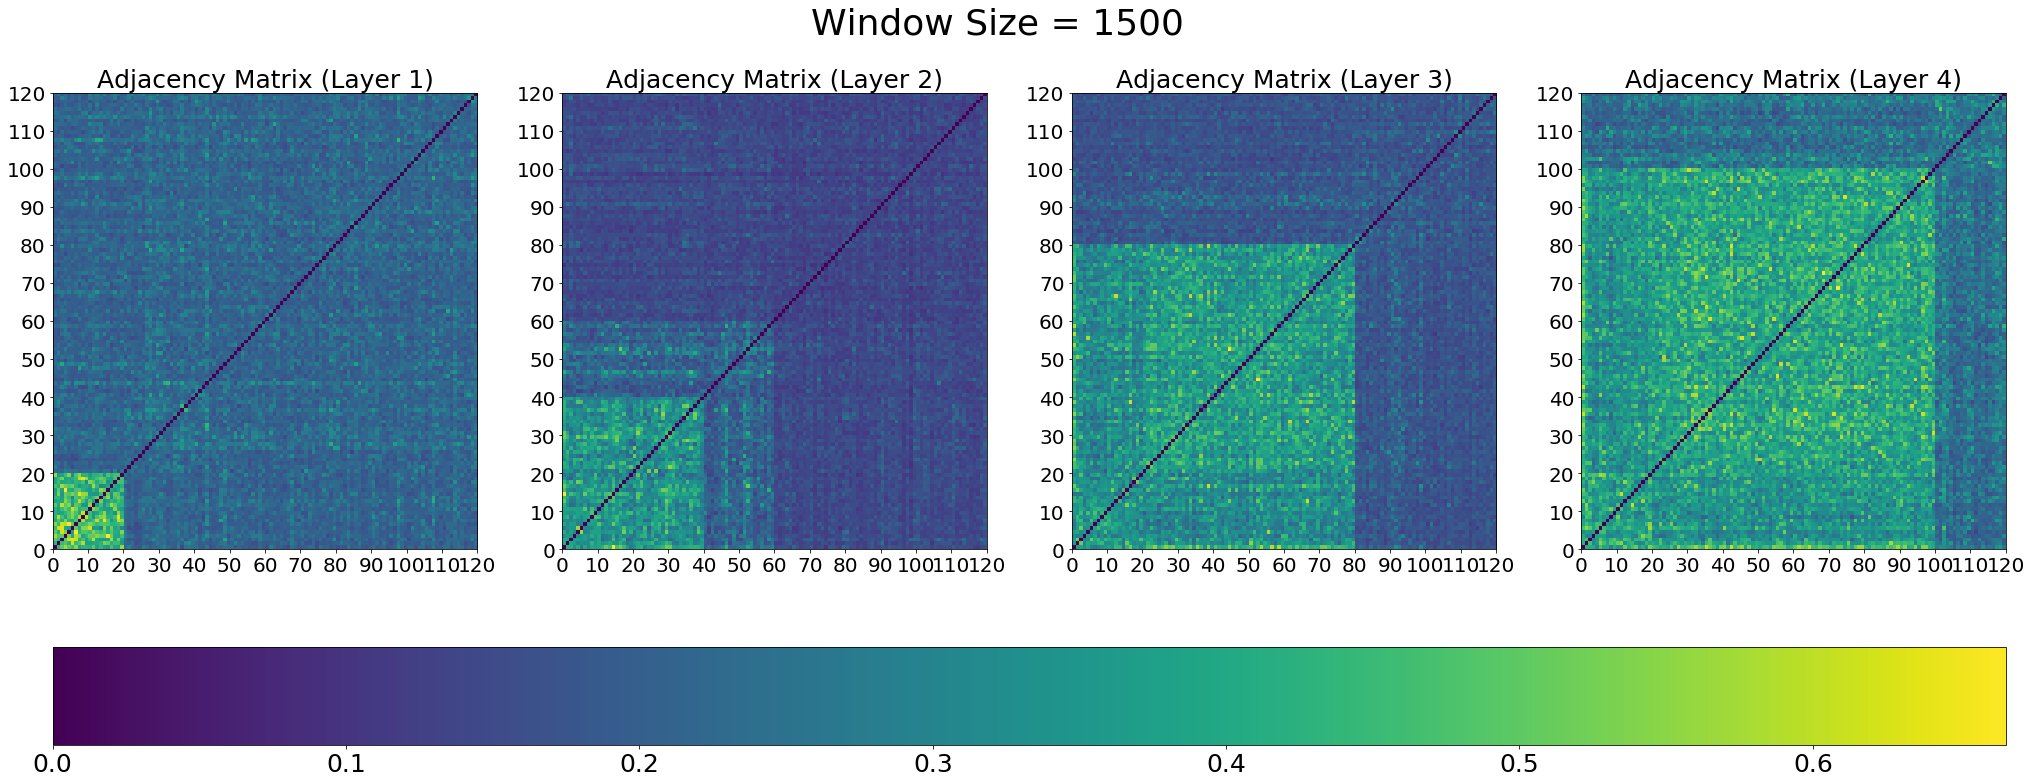

In [12]:
w = window_sizes[3]
layers = int(total_duration/w)

fig,ax = plt.subplots(1, layers, figsize = (35,12))
for i in range(layers):
    k = ax[i].imshow(adjacencies['%d'%w][i], 
                            origin = 'lower', 
                            interpolation='nearest', 
                            aspect='auto',  
                            extent = [0, num_neurons, 0, num_neurons])
    ax[i].set_title('Adjacency Matrix (Layer %d)'%(i+1), fontsize = 25)
    ax[i].set_xticks([k*10 for k in range(int(num_neurons/10)+1)])
    ax[i].set_yticks([k*10 for k in range(int(num_neurons/10)+1)])
    ax[i].tick_params(axis = 'both', labelsize = 20)
fig.suptitle("Window Size = %d"%w, fontsize=36)
cbar = fig.colorbar(k, ax = ax.flat, orientation = 'horizontal')
cbar.ax.tick_params(labelsize = 25) 

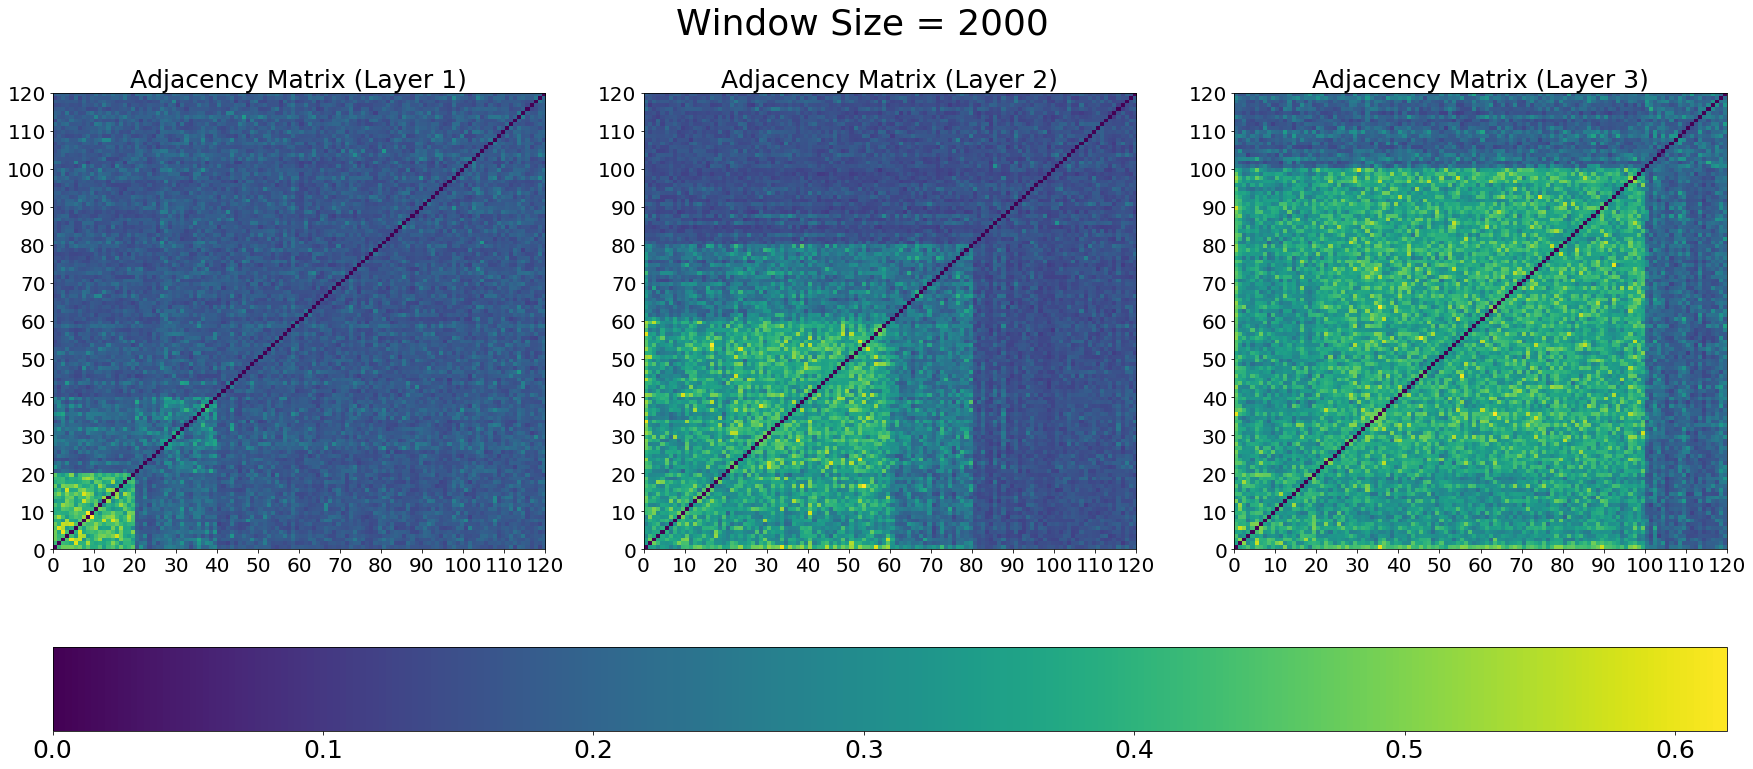

In [13]:
w = window_sizes[4]
layers = int(total_duration/w)

fig,ax = plt.subplots(1, layers, figsize = (30,12))
for i in range(layers):
    k = ax[i].imshow(adjacencies['%d'%w][i], 
                            origin = 'lower', 
                            interpolation='nearest', 
                            aspect='auto',  
                            extent = [0, num_neurons, 0, num_neurons])
    ax[i].set_title('Adjacency Matrix (Layer %d)'%(i+1), fontsize = 25)
    ax[i].set_xticks([k*10 for k in range(int(num_neurons/10)+1)])
    ax[i].set_yticks([k*10 for k in range(int(num_neurons/10)+1)])
    ax[i].tick_params(axis = 'both', labelsize = 20)
fig.suptitle("Window Size = %d"%w, fontsize=36)
cbar = fig.colorbar(k, ax = ax.flat, orientation = 'horizontal')
cbar.ax.tick_params(labelsize = 25) 

## Compute entropy for the number of spikes falling into windows of varying sizes

In [97]:
%%time
counters = {}
binned_spikes = {}
for j,window_size in enumerate(window_sizes):
    binned_spikes['%d'%window_size] = bin_time_series(spikes, window_size, gaussian = False) 
    layers, neurons, windowsize = binned_spikes['%d'%window_size].shape
    counter = np.zeros((neurons,layers))
    for k in range(len(np.transpose(np.nonzero(binned_spikes['%d'%window_size])))):
        l, n ,t = np.transpose(np.nonzero(binned_spikes['%d'%window_size]))[k]
        counter[n][l] = counter[n][l] + 1
    counters['%d'%window_size] = counter

CPU times: user 5min 27s, sys: 3.37 s, total: 5min 30s
Wall time: 5min 49s


In [103]:
pdf_neurons = {}
for i,e in enumerate(window_sizes):
    temp = np.zeros(counters['%d'%e].shape)
    for n in range(num_neurons):
        temp[n] = counters['%d'%e][n]/np.sum(counters['%d'%e][n]) 
    pdf_neurons['%d'%e] = temp

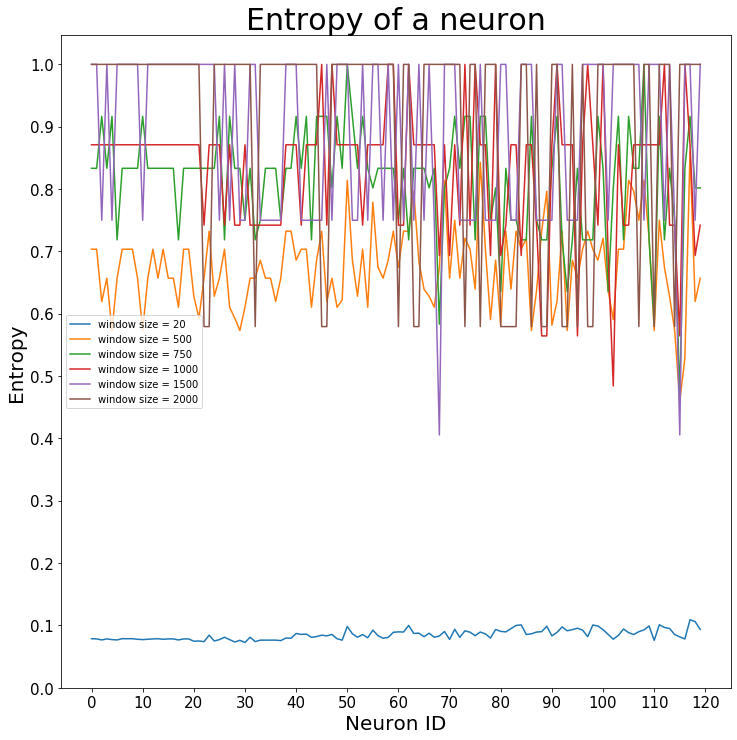

In [116]:
fig,ax = plt.subplots(1, 1, figsize = (12,12))
for j,e in enumerate(window_sizes):
    entropy_of_a_neuron = []
    for n in range(num_neurons):
        entropy_of_a_neuron.append(entropy2(pdf_neurons['%d'%e][n]))
    ax.plot(entropy_of_a_neuron, label = 'window size = %d'%e)
ax.set_title('Entropy of Neurons', fontsize = 30)
ax.set_xlabel('Neuron ID', fontsize = 20)
ax.set_ylabel('Entropy', fontsize=20)
ax.set_xticks([i*10 for i in range(int(num_neurons/10)+1)])
ax.set_yticks([i*0.1 for i in range(11)])


ax.tick_params(axis = 'both', labelsize = 15)


ax.legend(loc = 'best')

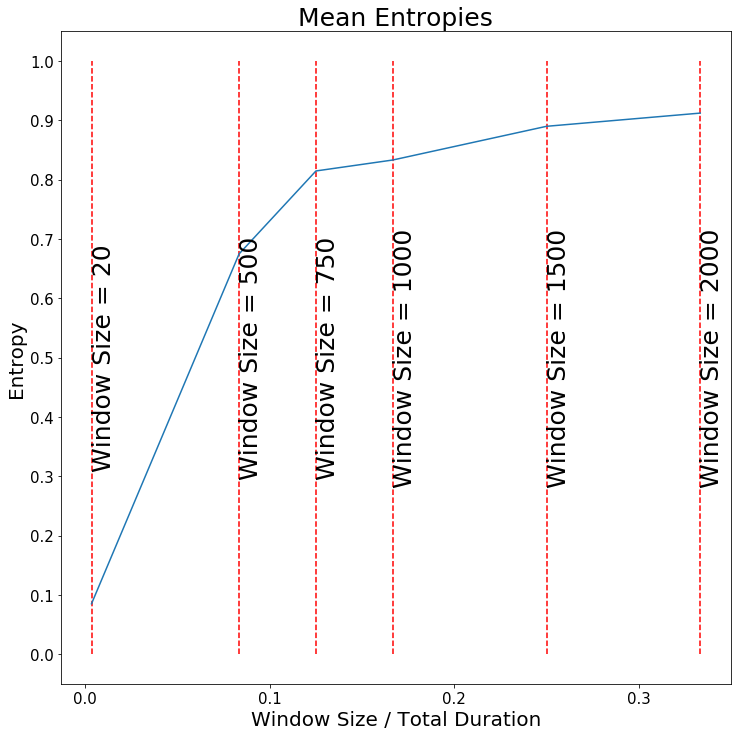

In [139]:
fig,ax = plt.subplots(1, 1, figsize = (12,12))
mean_entropies = []
for j,e in enumerate(window_sizes):
    entropy_of_a_neuron = []
    for n in range(num_neurons):
        entropy_of_a_neuron.append(entropy2(pdf_neurons['%d'%e][n]))
    mean_entropies.append(np.mean(entropy_of_a_neuron))

ax.plot(np.array(window_sizes)/total_duration, mean_entropies)
for i,e in enumerate(np.array(window_sizes)/total_duration):
    ax.vlines(e,0,1, linestyle = 'dashed', color = 'r')
    ax.text(e, 0.5, 'Window Size = %d'%(int(e*total_duration)), rotation=90, verticalalignment='center', fontsize =25)
ax.set_title('Mean Entropies', fontsize= 25)
ax.set_xlabel('Window Size / Total Duration', fontsize= 20)
ax.set_ylabel('Entropy', fontsize = 20)
ax.set_xticks([i*0.1 for i in range(int(10*np.max(np.array(window_sizes)/total_duration))+1)])
ax.set_yticks([i*0.1 for i in range(11)])


ax.tick_params(axis = 'both', labelsize = 15)